In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
sns.set(style='white', context='notebook', palette='deep')

In [4]:
# test,train data pd read csv
train_data = pd.read_csv('../input/digit-recognizer/train.csv')
test_data = pd.read_csv('../input/digit-recognizer/test.csv')

In [5]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
y_train = train_data['label']

In [7]:
x_train = train_data.drop(labels= ['label'], axis = 1)

In [8]:
del train_data

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

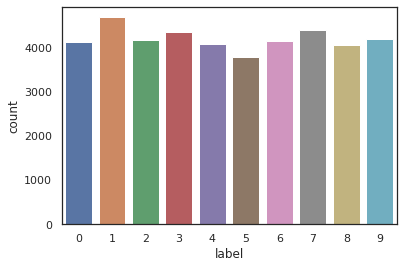

In [9]:
g = sns.countplot(y_train)

y_train.value_counts()

In [10]:
x_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [11]:
test_data.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [12]:
# 정규화 / 255.0
x_train /= 255.0
test_data /= 255.0

In [13]:
# (-1, 28, 28, 1)
x_train = x_train.values.reshape(-1, 28, 28, 1)
test_data = test_data.values.reshape(-1, 28, 28, 1)

In [14]:
# to_categorical
y_train = to_categorical(y_train, num_classes=10)

In [15]:
# train,valid train_test_split 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

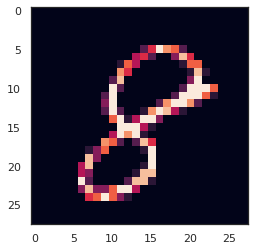

In [16]:
g = plt.imshow(x_train[0][:,:,0])

In [17]:
# cnn 모델 
# Featrue Extraction

# Classifer
model = Sequential([
        Conv2D(32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(28, 28, 1)),
        Conv2D(32, kernel_size=(5, 5), padding='Same', activation='relu'),
        MaxPool2D(2),
        Dropout(0.25),
    
        Conv2D(64, kernel_size=(3, 3), padding='Same', activation='relu'),
        Conv2D(64, kernel_size=(3, 3), padding='Same', activation='relu'),
        MaxPool2D(pool_size=2, strides=(2,2)),
        Dropout(0.25),
    
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
])


In [18]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [19]:
# compile
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
lrr = ReduceLROnPlateau(monitor='val_acc', patience=3, factor=0.5, min_lr=0.00001)

In [21]:
epochs = 10
batch_size = 86

In [22]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [24]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,
                               validation_data = (x_val, y_val),
                               verbose=2, steps_per_epoch=x_train.shape[0],
                               callbacks=[lrr])

Epoch 1/10
  440/37800 - 13s - loss: 0.4121 - accuracy: 0.8690 - val_loss: 0.0586 - val_accuracy: 0.9805


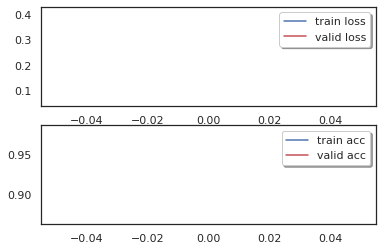

In [27]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']

# fig, ax = plt.subplots(2, 1)
# ax[0].plot(loss, 'b', label='train loss')
# ax[0].plot(val_loss, 'r', label='valid loss', axes=ax[0])
# legend = ax[0].legend(loc='best', shadow=True)

# ax[1].plot(acc, 'b', label='train acc')
# ax[1].plot(val_acc, 'r', label='valid acc')
# legend = ax[1].legend(loc='best', shadow=True)

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

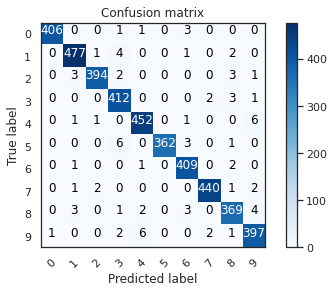

In [30]:
prediction = model.predict(x_val)

prediction_class = np.argmax(prediction, axis = 1)

real = np.argmax(y_val, axis = 1)

confusion_mtx = confusion_matrix(real, prediction_class)

plot_confusion_matrix(confusion_mtx, classes=range(10))

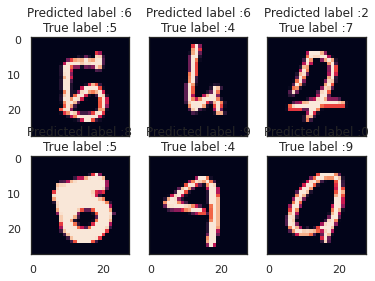

In [32]:
errors = (prediction_class - real != 0)

Y_pred_classes_errors = prediction_class[errors]
Y_pred_errors = prediction[errors]
Y_true_errors = real[errors]
X_val_errors = x_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [34]:
results = model.predict(test_data)

results = np.argmax(results, axis = 1)

results = pd.Series(results, name='Label')

In [35]:
submission = pd.concat([pd.Series(range(1, 28001), name='ImageId'), results], axis=1)
submission.to_csv('mnist-submission.csv', index=False)

NameError: name 'd' is not defined